<a href="https://colab.research.google.com/github/iceman011/mydeeplearning/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/style_tx_cat.png?raw=1' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

Current Epoch: 100 ,Content loss: 9.516364097595215 ,Style loss:173.9398193359375  ,Total loss: 173939840.0


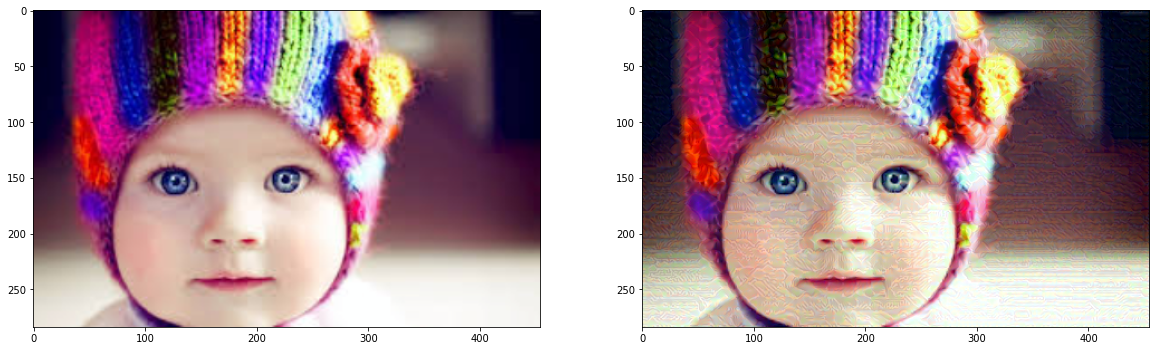

Current Epoch: 200 ,Content loss: 11.132904052734375 ,Style loss:89.43388366699219  ,Total loss: 89433888.0


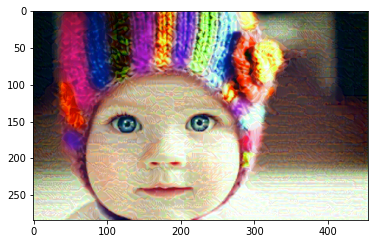

Current Epoch: 300 ,Content loss: 12.010924339294434 ,Style loss:54.32878875732422  ,Total loss: 54328800.0


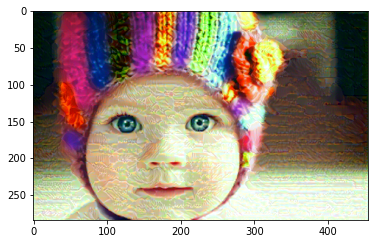

Current Epoch: 400 ,Content loss: 12.526318550109863 ,Style loss:34.60368347167969  ,Total loss: 34603696.0


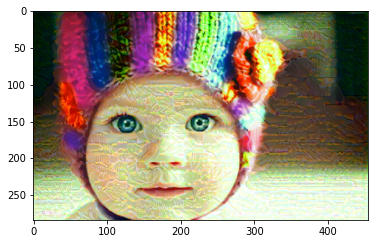

Current Epoch: 500 ,Content loss: 12.88757610321045 ,Style loss:23.23629379272461  ,Total loss: 23236306.0


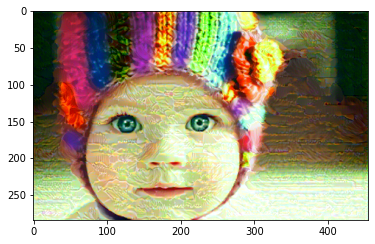

Current Epoch: 600 ,Content loss: 13.171420097351074 ,Style loss:16.877485275268555  ,Total loss: 16877500.0


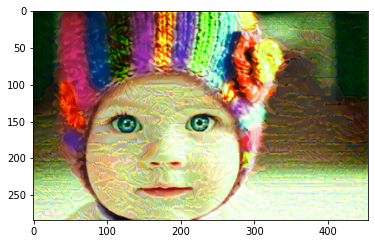

Current Epoch: 700 ,Content loss: 13.42265796661377 ,Style loss:13.103228569030762  ,Total loss: 13103242.0


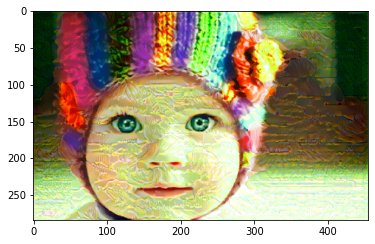

Current Epoch: 800 ,Content loss: 13.618731498718262 ,Style loss:10.612221717834473  ,Total loss: 10612236.0


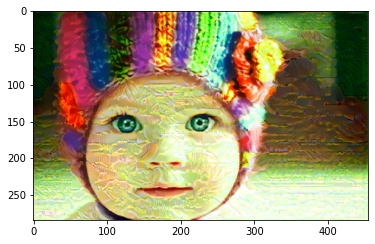

Current Epoch: 900 ,Content loss: 13.775222778320312 ,Style loss:8.830665588378906  ,Total loss: 8830680.0


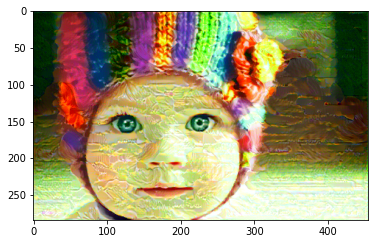

Current Epoch: 1000 ,Content loss: 13.891164779663086 ,Style loss:7.500626087188721  ,Total loss: 7500640.0


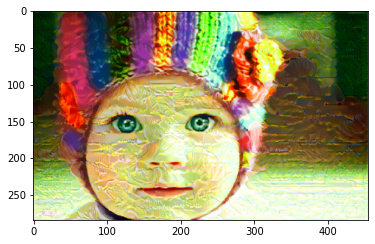

Current Epoch: 1100 ,Content loss: 13.992493629455566 ,Style loss:6.479877471923828  ,Total loss: 6479891.5


In [0]:
#ORGINAL LINK IS BELOW
#https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

##############################################
# PAREPARE VGG PRETRAINED MODEL
############################################
def prepare_model():
  # get the "features" portion of VGG19 (we will not need the "classifier" portion)
  vgg = models.vgg19(pretrained=True).features

  # freeze all VGG parameters since we're only optimizing the target image
  for param in vgg.parameters():
      param.requires_grad_(False)
  return vgg

##########################################
# GET FEATURES FROM VGG MODEL
##############################################
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

#############################################
# BUILD GRAM MATRIX
#############################################
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

###############################################
# iniTIALIZE WEIGHTS
###############################################
def init_weights(style_weights=None,content_weight =1, style_weight=1e6):
  # weights for each style layer 
  # weighting earlier layers more will result in *larger* style artifacts
  # notice we are excluding `conv4_2` our content representation
  if not style_weights:
    style_weights = {'conv1_1': 1.,
                    'conv2_1': 0.75,
                    'conv3_1': 0.2,
                    'conv4_1': 0.2,
                    'conv5_1': 0.2}

  content_weight = content_weight # alpha
  style_weight = style_weight  # beta
  return style_weights , content_weight , style_weight

#####################################
# BUILD CONENT & STYLE FEATURES
######################################
def build_features(content ,style,model):
  # get content and style features only once before training
  content_features = get_features(content, model)
  style_features = get_features(style, model)
  return content_features , style_features

#####################################
# CALC GRAMS OF STYLE FEATURES
######################################
def calc_style_grams(style_features):
  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
  return style_grams

#####################################
# LOAD IMAGE FROM LOCAL OR WEB ADSRESS
######################################
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image      

##########################################
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
##########################################
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


#######################################
# DEBUG INTERMEDIATE STATES
###########################################
def view_target_featuers(target_featuers):
  fig = plt.figure(figsize=(10, 6))
  i = 0
  for layer_name in target_features:
    layer = target_features[layer_name]
    image = layer.to("cpu").clone().detach()
    image = image.numpy().squeeze()

    
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    
    ax.imshow(image[0,:,:])
    ax.set_title('LayerName %s' % layer_name)
    i+=1

    #fig, (ax1, ax2) = plt.subplots(1, 5, figsize=(20, 10))

#########################################################
# DISPLAY FINAL TARGET IN REGARD TO ORGINAL CONTENT & STYLE
##############################################################
def display_final(content,style,target):
  # display content and final, target image
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))
  ax3.imshow(im_convert(target))

##########################################
# STYLE TRANSFER TRAINING USING VGG
############################################
def train_style_transfer(model,device,content,content_features,content_weight,style_weights,style_grams,style_weight,lr=0.003,epochs=3000,show_every=100):
  # create a third "target" image and prep it for change
  # it is a good idea to start off with the target as a copy of our *content* image
  # then iteratively change its style
  target = content.clone().requires_grad_(True).to(device)

  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=lr)

  for epoch in range(1, epochs+1):
      
      # get the features from your target image
      target_features = get_features(target, model)
      
      # the content loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      
      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # then add to it for each layer's gram matrix loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_gram = gram_matrix(target_feature)
          _, d, h, w = target_feature.shape
          # get the "style" style representation
          style_gram = style_grams[layer]
          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)
          
      # calculate the *total* loss
      total_loss = content_weight * content_loss + style_weight * style_loss
      
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      # display intermediate images and print the loss
      if  epoch % show_every == 0:
          print("Current Epoch: {} ,Content loss: {} ,Style loss:{}  ,Total loss: {}".format(epoch,content_loss,style_loss,total_loss.item()))
          plt.imshow(im_convert(target))
          plt.show()
          #view_target_featuers(target_features)
  return target    

#########################################
# MAIN FUNCTION
############################################
def MAIN():
  # move the model to GPU, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # load in content and style image
  #content = load_image('https://www.laketobias.com/wp-content/uploads/bengal-tiger.jpg').to(device)
  content = load_image('./kid5.jpg').to(device)
  # Resize style to match content, makes code easier
  style = load_image('https://st4.depositphotos.com/1201487/23488/i/1600/depositphotos_234882912-stock-photo-abstract-colorful-flowers-hand-painted.jpg', shape=content.shape[-2:]).to(device)

  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))

  model = prepare_model()
  model.to(device)
  style_weights , content_weight , style_weight =  init_weights(style_weights=None,content_weight =1, style_weight=1e6)

  content_features , style_features = build_features(content ,style,model)
  style_grams = calc_style_grams(style_features)

  target = train_style_transfer(model,device,content,content_features,content_weight,style_weights,style_grams,style_weight,lr=0.003,epochs=3000,show_every=100)

  display_final(content,style,target)




MAIN()

In [0]:
pip list